In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
print(f"Last edit: {datetime.datetime.now()}")

Last edit: 2025-08-16 08:15:16.821624


In [3]:
# Are we using a GPU?
# If not, and you're in Google Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
!nvidia-smi

Sat Aug 16 08:15:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-08-16 08:15:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-08-16 08:15:46 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [6]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-08-16 08:16:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 192.178.163.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  69.6MB/s    in 13s     

2025-08-16 08:16:41 (115 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_clas

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [10]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [11]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## OLD
# # Setup data augmentation
# from tensorflow.keras.layers.experimental import preprocessing
# data_augmentation = Sequential([
#   preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
#   preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
#   preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
#   preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
#   preprocessing.RandomZoom(0.2), # randomly zoom into an image
#   # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

In [12]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Get a summary of our model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 57s 174ms/step - accuracy: 0.1563 - loss: 3.9751 - val_accuracy: 0.4746 - val_loss: 2.4269
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 157ms/step - accuracy: 0.4867 - loss: 2.3238 - val_accuracy: 0.5297 - val_loss: 1.9822
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.5508 - loss: 1.9144 - val_accuracy: 0.5331 - val_loss: 1.8545
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.5903 - loss: 1.6844 - val_accuracy: 0.5482 - val_loss: 1.7609
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.6244 - loss: 1.5417 - val_accuracy: 0.5577 - val_loss: 1.7110


In [15]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5632 - loss: 1.6768


[1.588995099067688, 0.5841187834739685]

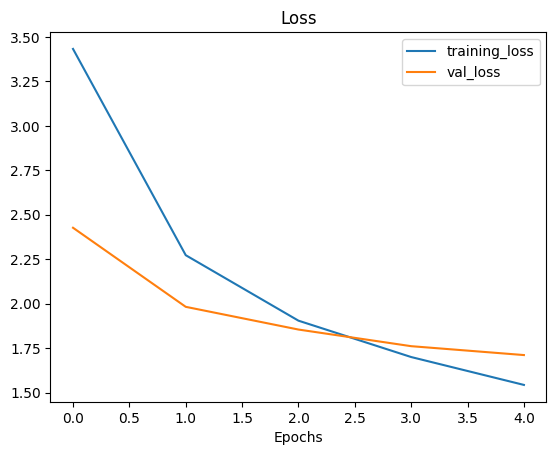

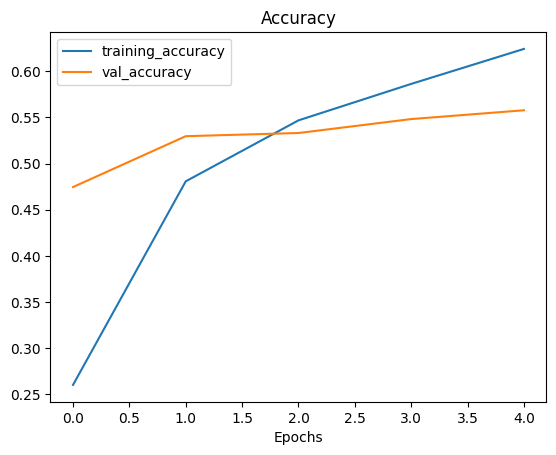

In [16]:
plot_loss_curves(history_all_classes_10_percent)

In [17]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [19]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [20]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.6302 - loss: 1.5192 - val_accuracy: 0.5628 - val_loss: 1.6851
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - accuracy: 0.6761 - loss: 1.3316 - val_accuracy: 0.5757 - val_loss: 1.6311
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.7046 - loss: 1.2274 - val_accuracy: 0.5850 - val_loss: 1.6018
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.7096 - loss: 1.1741 - val_accuracy: 0.5816 - val_loss: 1.5917
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.7193 - loss: 1.1247 - val_accuracy: 0.5885 - val_loss: 1.5738
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.7390 - loss: 1.0679 - val_accuracy: 0.5879 - val_loss: 1.5766


In [22]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.6045 - loss: 1.4951


[1.4147461652755737, 0.6204356551170349]

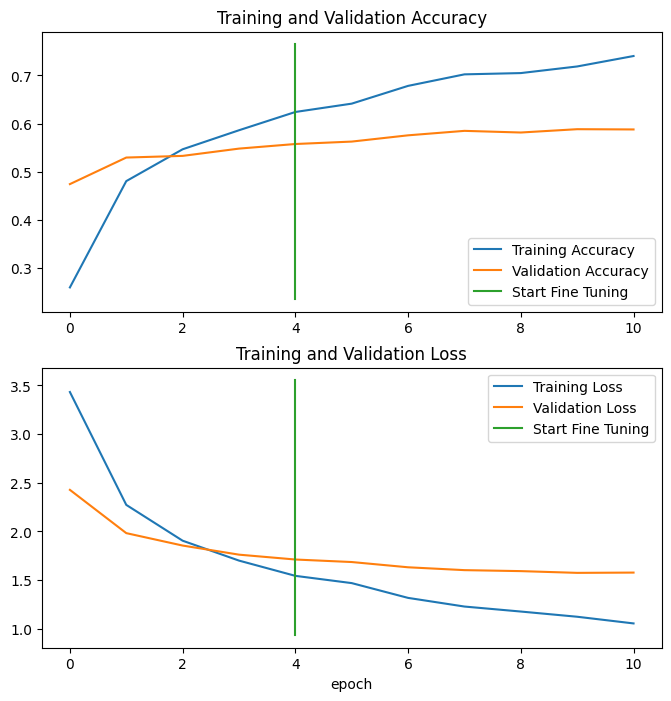

In [23]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [28]:
model.save("drive/My Drive/Dive into deep learning with tensorflow/models/101_food_class_10_percent_saved_big_dog_model.keras")

In [30]:
import tensorflow as tf

# Download and unzip as before
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Use TensorFlow's SavedModel loader instead of Keras
model_folder = saved_model_path.split(".")[0]
model = tf.saved_model.load(model_folder)

# For inference, you'll use: model(input_data) or model.signatures['serving_default'](input_data)

--2025-08-16 08:34:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   179MB/s    in 0.2s    

2025-08-16 08:34:49 (179 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [32]:
# Install tf-keras for Keras 2 compatibility
!pip install tf-keras

# Import tf-keras instead of keras
import tf_keras as keras
import tensorflow as tf

# Load the model using tf-keras
model_folder = saved_model_path.split(".")[0]
model = keras.models.load_model(model_folder)

# Now this will work:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 55s 68ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027204275131226, 0.6077623963356018)